### RFC

### import modules and configure notebook

In [1]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats
%store -r X_test_labeled_df
%store -r site_frequencies_df



### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to
* modelName -> string, type of model to use 'rfc'|'gbm'|'svm'|'knn'
* trainTestSplitTotalIters -> total number of iterations of train test split for cross validation

In [3]:
save_plots = True
random_seed_state = 42
classify_bedrock_only = False
grid_search = False
scale = True
save_predictions = False
modelName = 'svm'


### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### counts of instances in all classes before oversampling

In [4]:
train_data_formodel['class'].value_counts()

4     105
17    100
18     61
0      53
10     47
13     45
15     36
16     36
2      36
12     30
11     30
8      30
7      30
5      30
6      27
9      27
1      24
14     21
3      18
Name: class, dtype: int64

### The class column is stored as the variable y 

In [5]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [6]:
train_data_feats = train_data_formodel[best_feats]

### address class imbalance using synthetic minority oversampling technique (SMOTE) algorithm

In [7]:
if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(np.array(train_data_feats)))
else:
    X = np.array(np.array(train_data_feats))

### the dimensions of the class and features are checked

In [8]:
print(X.shape)
print(y.shape)

(786, 25)
(786,)


In [9]:
skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)

for train_index, test_index in skf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    

### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores are calculated

In [10]:
if modelName == 'rfc':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)

    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0



    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y)
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)


        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = RandomForestClassifier(max_features = 'auto', random_state = random_seed_state)

        n_estimators = [2000, 2500, 3000]
        max_depth = [80, 100, 120]
        min_samples_split = [2, 3, 4]
        min_samples_leaf = [1, 2, 3]

        param_grid = {
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'n_estimators':n_estimators 
                      }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid search on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        feat_imp_dict[key] = optimumEstimator.feature_importances_
        
 

In [11]:
if modelName == 'gbm':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)

    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0



    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)


        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = xgb.XGBClassifier(n_estimators=5)


        max_depth = [80, 100, 120]
        min_child_weight = [0,1,3]
        gamma = [0,3,5,7,9]



        param_grid = {
                   'max_depth': max_depth,
                       'min_child_weight':min_child_weight,
                       'gamma':gamma
                      }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid search on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        feat_imp_dict[key] = optimumEstimator.feature_importances_

In [12]:
if modelName == 'svm':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)

    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0

  
    for train_index, test_index in skf.split(X, y):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)
        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = SVC()


        param_grid = {
            'C': [0.01, 0.1, 1, 10, 100], 
            'class_weight':['balanced', None], 
            'gamma':[0.001, 0.01, 0.1, 1, 10]
                }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid search on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        #feat_imp_dict[key] = optimumEstimator.feature_importances_

making model:
1
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   26.0s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no

gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
2
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.5s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no

gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
3
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.0s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
4
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.5s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
5
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.4s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
6
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
7
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
8
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.7s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
9
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
10
running grid search on this training data fold
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   13.3s


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   24.8s finished
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
f1_df = pd.DataFrame(data = f1_dict)


In [14]:
for key in f1_dict:
    print(len(f1_dict[key]))

19
19
19
19
19
19
19
19
19
19


### Below are the encodings for the class variable

In [15]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB_BX', 'PF', 'BM', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB']


In [16]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [17]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

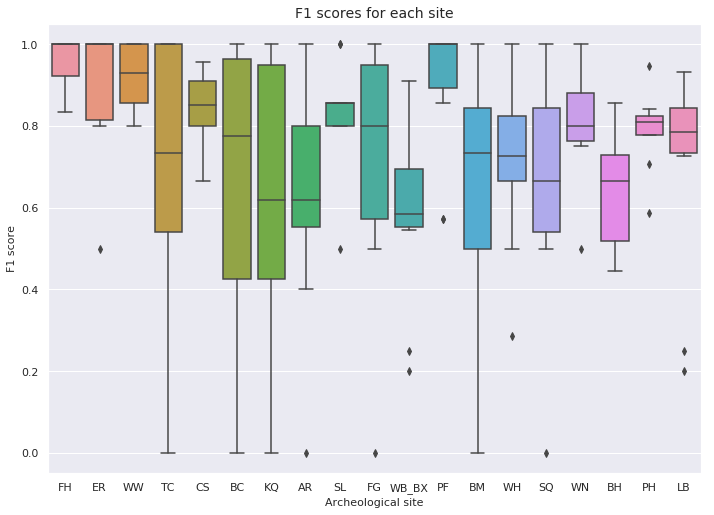

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Archeological site", fontdict={'fontsize': 11})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('figures/site_specific_f1_scores.png')

In [19]:
if save_plots:
    pd.DataFrame(data = f1_df_final.T.median()).to_csv('figures/median_class_f1_scores.csv')

### Boxplot showing the macro F1 score

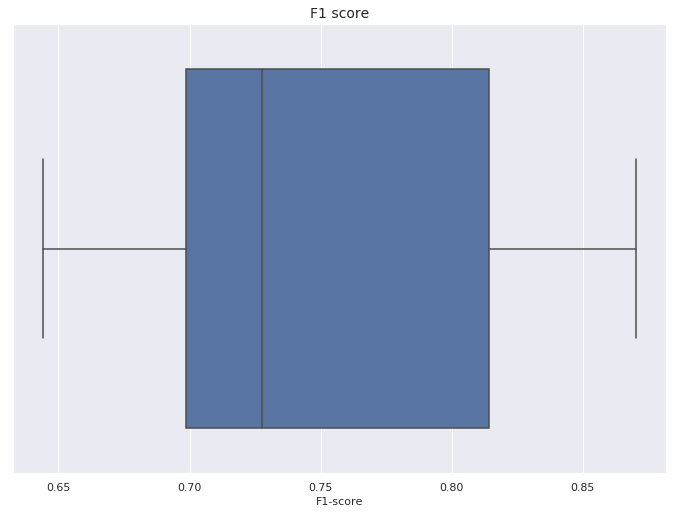

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(macro_f1_scores)
plot.set_title('F1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('figures/average-weighted f1_scores.png')

In [21]:
if save_plots:
    pd.Series(pd.Series(macro_f1_scores).median()).to_csv('median_macro_f1.csv')

In [22]:
pd.Series(macro_f1_scores).median()

0.7278043974840313

### Boxplot showing accuracy scores

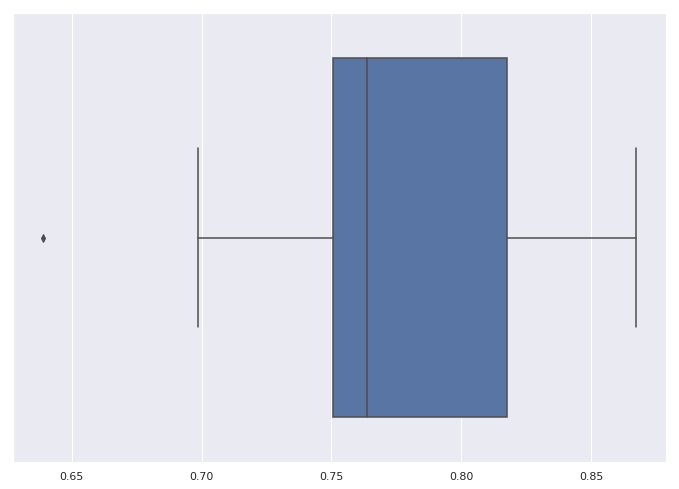

In [23]:
sns.boxplot(accuracy_scores)

### Get feature importances

In [24]:
feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

""


In [25]:
feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[best_feats].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

,element
0,Li7
1,Nd146
2,Pr141
3,La139
4,Ba137


In [26]:
feat_imp_df_final.set_index('element', inplace=True)


In [27]:
feat_imp_df_final_plot = feat_imp_df_final.T

In [28]:
feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

In [29]:
mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

In [30]:
mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

In [31]:
mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

In [32]:
ordered_col_names = list(mean_feature_importance_df['elements'])

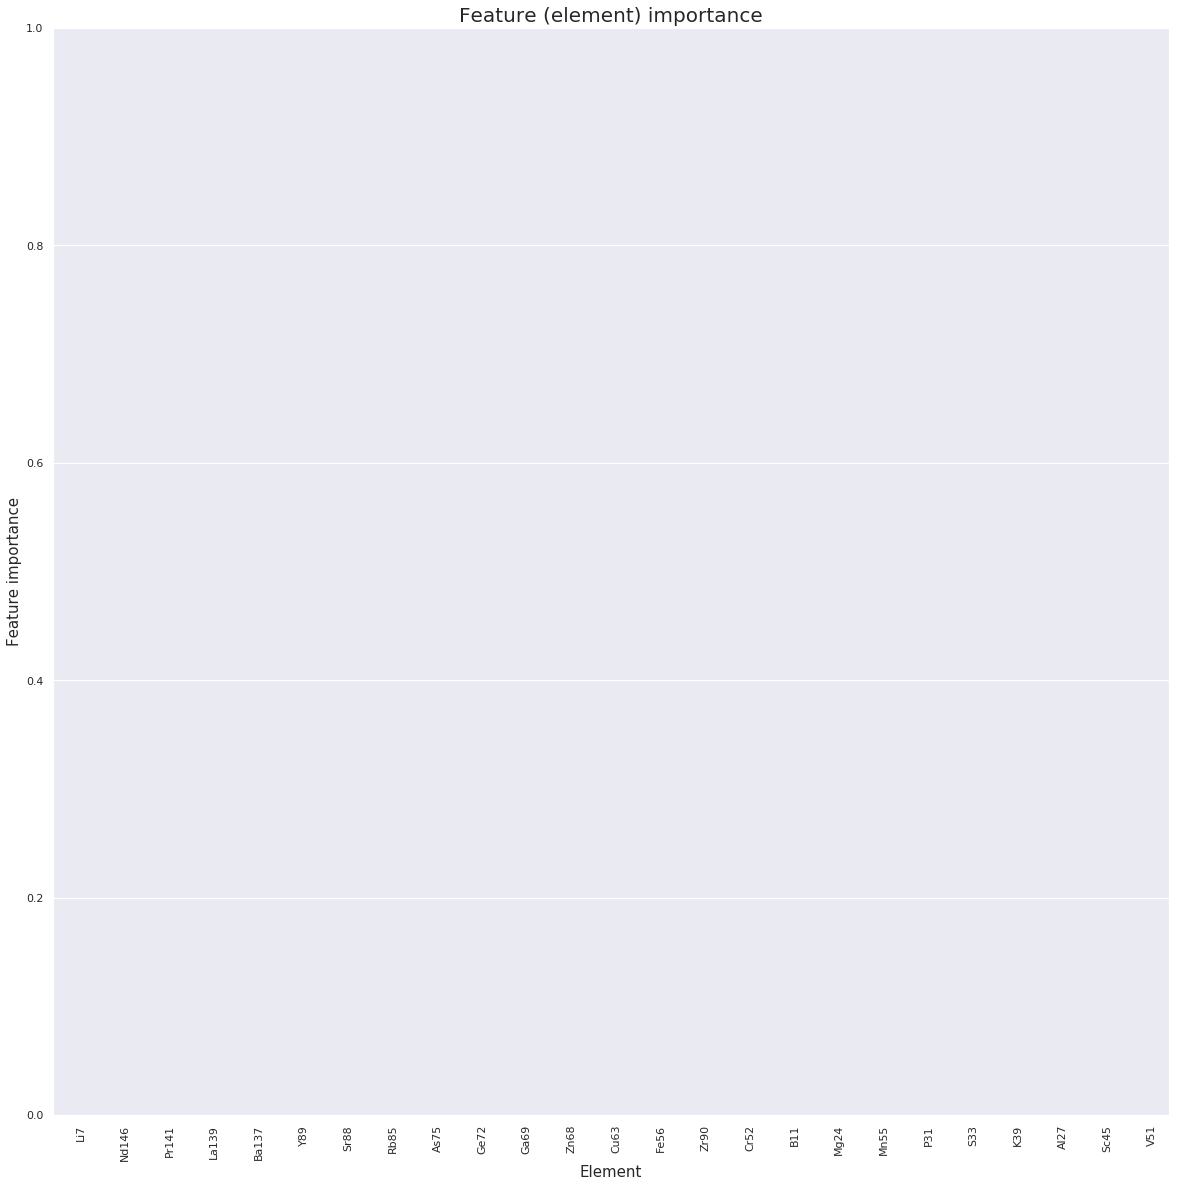

In [33]:
sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('figures/feature_importances.png')

### show relationship between sample size and class F1 scores

In [34]:
site_frequencies_df.head()

,Site,Number of Observations
0,CS,105
1,PH,102
2,Pimple,78
3,LB,61
4,CR,60


In [35]:
site_frequencies_df.rename(columns = {'Site':'class'}, inplace=True)

In [36]:
f1_scores_for_plot = f1_df_final.reset_index(drop = False)

In [37]:
f1_scores_for_plot['Mean F1 Score'] = f1_scores_for_plot.mean(axis = 1)

In [38]:
combined_df = site_frequencies_df.set_index('class').join(other = f1_scores_for_plot.set_index('class'), how = 'inner')

In [39]:
forPlot = combined_df.reset_index(drop = False).rename(columns = {'index':'class'})[['class', 'Number of Observations', 'Mean F1 Score']]

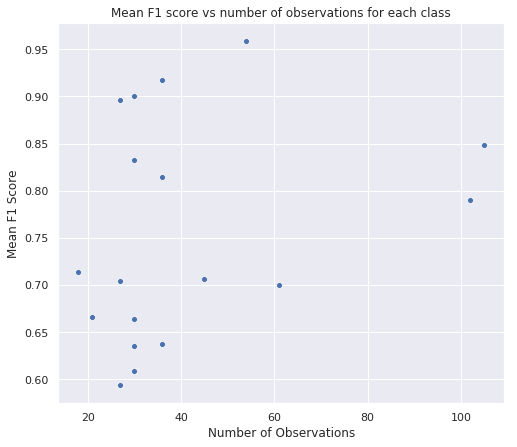

In [40]:
sns.set(rc={'figure.figsize':(8,7)})
plot = sns.scatterplot(x ='Number of Observations', y = 'Mean F1 Score', data = forPlot, ci=False)
ax = plt.gca()
ax.set_title("Mean F1 score vs number of observations for each class")
fig = plot.get_figure()
if save_plots:
    fig.savefig('figures/f1scoresvsnumberobservations{0}.png'.format(modelName))




In [41]:
forPlot

,class,Number of Observations,Mean F1 Score
0,CS,105,0.848236
1,PH,102,0.790439
2,LB,61,0.699607
3,FH,54,0.958858
4,WH,45,0.706407
5,WW,36,0.917143
6,WN,36,0.814603
7,BH,36,0.637302
8,BM,30,0.609206
9,PF,30,0.900000


In [42]:
f1_scores_for_plot.head()

,class,round1,round2,round3,round4,round5,round6,round7,round8,round9,round10,Mean F1 Score
0,FH,0.909091,0.923077,0.923077,1.000000,1.000000,1.000000,0.833333,1.0,1.000000,1.0,0.958858
1,ER,0.857143,1.000000,1.000000,1.000000,0.800000,1.000000,0.500000,0.8,1.000000,1.0,0.895714
2,WW,0.857143,1.000000,0.857143,1.000000,0.857143,1.000000,0.800000,0.8,1.000000,1.0,0.917143
3,TC,0.000000,0.666667,1.000000,0.500000,1.000000,0.800000,0.666667,1.0,0.500000,1.0,0.713333
4,CS,0.785714,0.952381,0.956522,0.833333,0.869565,0.909091,0.909091,0.8,0.666667,0.8,0.848236
